In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import ifft, fft, fftfreq
import pandas as pd
from scipy.optimize import minimize

In [3]:
dictionary = {123:'the definition of 123', 333:1}

In [4]:
import os

directory = './mdo3034_data/'
data = {}

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        split_filename = f.split('/')[2].split('.')[0]
        print(split_filename)
        data[split_filename] = np.array(pd.read_csv(f, skiprows=range(16), usecols=[3, 4]))
       

Pulse_12ns_AC
Pulse_12ns_CB50
Pulse_12ns_CC50
Pulse_12ns_CK50
Pulse_12ns_DoubleShort
Pulse_12ns_ShortCable
Pulse_24ns_AC
Pulse_24ns_CB50
Pulse_24ns_CC50
Pulse_24ns_CK50
Pulse_24ns_DoubleShort
Pulse_24ns_ShortCable
SineWave_160M_AC
SineWave_160M_CB50
SIneWave_160M_CC50
SineWave_160M_CK50
SineWave_160M_DoubleShort
SineWave_160M_ShortCable
SquareWave_10K_AC
SquareWave_10K_CB50
SquareWave_10K_CC50
SquareWave_10K_CK50
SquareWave_10K_DoubleShort
SquareWave_10K_ShortCable
SquareWave_1M_AC
SquareWave_1M_CB50
SquareWave_1M_CC50
SquareWave_1M_CK50
SquareWave_1M_DoubleShort
SquareWave_1M_ShortCable


In [5]:
def dB(x):
    if (x <= 0).any():
        print(x[x <= 0])
        print(1/0)
    return 20 * np.log10(x)

In [147]:
cableNames = ['AC', 'CC50', 'CB50', 'CK50', 'DoubleShort', 'ShortCable']
WaveForms = ['Pulse', 'SquareWave', 'SineWave']
cable_lengths = {'AC':2.234, 'CB50':220, 'CC50':1.6, 'CK50':18.8}

def Transfer(cable_short, cable_long, phase_fit_range, phase_slope, mag_fit_range, switch_range):
    short_10K = None
    long_10K = None
    short_1M = None
    long_1M = None

    # print('bruh', flush=True)

    for key in list(data.keys()):
        if(cable_short in key and WaveForms[1] in key and '10K' in key):
            short_10K = data[key]
        if(cable_short in key and WaveForms[1] in key and '1M' in key):
            short_1M = data[key]
        if(cable_long in key and WaveForms[1] in key and '10K' in key):
            long_10K = data[key]
        if(cable_long in key and WaveForms[1] in key and '1M' in key):
            long_1M = data[key]
    
    # print(len(short_10K), short_10K[-1, 0] - short_10K[0,0])
    # print(len(short_1M), short_1M[-1, 0] - short_1M[0,0])
    # print(len(long_10K), long_10K[-1, 0] - long_10K[0,0])
    # print(len(long_1M), long_1M[-1, 0] - long_1M[0,0])
    # assert (short_10K[:,0] == short_1M[:,0]).all()
    # assert (short_10K[:,0] == long_1M[:,0]).all()
    # assert (short_10K[:,0] == long_10K[:,0]).all()

    plt.plot(short_1M[:, 0][:len(short_1M)//100], short_1M[:, 1][:len(short_1M)//100])
    plt.plot(long_1M[:, 0][:len(short_1M)//100], long_1M[:, 1][:len(short_1M)//100])
    plt.show()

    times = short_10K[:,0]
    freqs = fftfreq(len(times), np.mean(np.diff(times)))

    odd_mask10K = np.full(len(freqs), False)
    odd_mask10K[4::8] = True
    odd_mask1M = np.full(len(freqs), False)
    odd_mask1M[400::800] = True

    short_10K_mag = np.abs(fft(short_10K[:,1]))
    long_10K_mag = np.abs(fft(long_10K[:,1]))
    short_1M_mag = np.abs(fft(short_1M[:,1]))
    long_1M_mag = np.abs(fft(long_1M[:,1]))

    short_10K_phase = np.angle(fft(short_10K[:,1]))
    long_10K_phase = np.angle(fft(long_10K[:,1]))
    short_1M_phase = np.angle(fft(short_1M[:,1]))
    long_1M_phase = np.angle(fft(long_1M[:,1]))

    # print((freqs[odd_mask10K]).shape, ((long_10K_mag / short_10K_mag)[odd_mask10K]).shape)

    phase10K_shift = long_10K_phase - short_10K_phase
    phase1M_shift = long_1M_phase - short_1M_phase

    def odd_power(base, exponent):
        if exponent < 0:
            base[base == 0] = 1
        return np.sign(base)*np.power(np.abs(base),exponent)

    def Phase_func(parameters, freqs_minimize):
        return (parameters[0]/1e4) * (odd_power(freqs_minimize, parameters[1])) + (parameters[2]/1e6)*freqs_minimize 

    def objsfunc(parameters, freq_minimize, datas):
        return np.sum((Phase_func(parameters, freq_minimize) - datas)**2)  

    phase10K_shift[:len(phase10K_shift)//2] += freqs[:len(phase10K_shift)//2]*phase_slope
    phase10K_shift[phase10K_shift < -np.pi] += np.ceil((-phase10K_shift[phase10K_shift < -np.pi] + 1/2*np.pi)/(2*np.pi))*2*np.pi
    phase10K_shift[phase10K_shift > np.pi] -= np.ceil((phase10K_shift[phase10K_shift > np.pi] - 1/2*np.pi)/(2*np.pi))*2*np.pi

    phase10K_shift = phase10K_shift / cable_lengths[cable_long] * 100 

    # for i in range(len(freqs[odd_mask10K])//20):
    #     print(f'{freqs[odd_mask10K][i*20]}\t{(phase10K_shift)[odd_mask10K][i*20]}')

    args_phase = (freqs[odd_mask10K & (freqs >= 0) & (freqs < phase_fit_range)], phase10K_shift[odd_mask10K & (freqs >= 0) & (freqs < phase_fit_range)])

    guess1 = [-6.8, .4, .27]
    objsolutions = minimize(objsfunc, guess1, args = args_phase)

    plt.scatter(freqs[odd_mask10K], phase10K_shift[odd_mask10K], label= 'SquareWave 10K Hz', s=1)
    # plt.scatter(freqs[odd_mask1M], phase1M_shift[odd_mask1M], s=1)
    plt.plot(freqs[odd_mask10K & (freqs >= 0)], Phase_func(objsolutions.x, freqs)[odd_mask10K & (freqs >= 0)], label= 'Fitted Function', c='C1')

    plt.title(f"{cable_long}: Transfer Function Phase Difference" )
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (Radians per 100m)')
    plt.legend()
    plt.ylim(-np.pi/2,np.pi/2)
    plt.xlim(0,.45e8)
    plt.xticks(np.linspace(0, .45e8, 11))
    plt.grid()
    plt.gcf().set_size_inches(10, 6)
    plt.savefig("PhaseFigure.png",dpi=300)
    # text1 = f'Phase: $\\dfrac{{A}}{{10^4}}sign(f)|f|^B + \\dfrac{{C}}{{10^6}}f$\nA= {objsolutions.x[0]:.3f} \nB= {objsolutions.x[1]:.3f} \nC= {objsolutions.x[2]:.3f}'
    text1 = f'Phase: $A sign(f)|f|^B + C f$\nA= {objsolutions.x[0]:.3f}$\\times 10^{{-4}}$ \nB= {objsolutions.x[1]:.3f} \nC= {objsolutions.x[2]:.3f}$\\times 10^{{-6}}$'
    plt.text(.05, .5, text1, fontdict={'fontsize': 15}, transform=plt.gca().transAxes)
    plt.show()



    mag10K_ratio = long_10K_mag / short_10K_mag
    mag1M_ratio = long_1M_mag / short_1M_mag

    mag10K_ratio = dB(mag10K_ratio) / cable_lengths[cable_long] * 100
    mag1M_ratio = dB(mag1M_ratio) / cable_lengths[cable_long] * 100

    plt.scatter(freqs[odd_mask10K], mag10K_ratio[odd_mask10K], label= 'Magnitude 10K Hz', s=1)
    plt.scatter(freqs[odd_mask1M], mag1M_ratio[odd_mask1M], label= 'Magnitude 1M Hz', s=35, marker='x')

    # for i in range(len(freqs[odd_mask10K])//20):
    #     print(f'{freqs[odd_mask10K][i*20]}\t{(mag10K_ratio)[odd_mask10K][i*20]}')

    plt.xlim(1e3,3e8)
    plt.ylim(-20,2)
    plt.xscale('log')
    # plt.yscale('log')
    
    def param_func(parameters, freq_minimize):
        return -parameters[0] * (np.log10(np.abs(freq_minimize) + 10**parameters[1]) + parameters[2]) - 10**parameters[3] * np.abs(freq_minimize)

    def objfunc(parameters, freq_minimize, data):
        return np.sum((param_func(parameters, freq_minimize) - data)**2)

    guess = [3.19, 5.894,-5.807, -7.192]

    ratio_to_fit = mag10K_ratio.copy()

    ratio_to_fit[(freqs >= switch_range[0]) & (freqs < switch_range[1])] = np.interp(freqs[(freqs >= switch_range[0]) & (freqs < switch_range[1])], freqs[odd_mask1M & (freqs > 0)], (mag1M_ratio)[odd_mask1M & (freqs > 0)])
    # ratio_to_fit = dB(ratio_to_fit)
    # plt.scatter(freqs[odd_mask10K], ratio_to_fit[odd_mask10K], label= 'Composite of 10K & 1M Hz', s=1)

    args = (freqs[odd_mask10K & (freqs >= 0) & (freqs < mag_fit_range)], ratio_to_fit[odd_mask10K & (freqs >= 0) & (freqs < mag_fit_range)])

    objsolution = minimize(objfunc, guess, args = args)
    print(objsolution)
    

    plt.plot(freqs[(freqs >= 0)], param_func(objsolution.x, freqs)[(freqs >= 0)], label= 'Fitted Function', c='C3')
    plt.title(f"{cable_long}: Transfer Function Magnitude" )
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (Decibals per 100m)')
    plt.gca().axvspan(0, switch_range[0], color='C0', alpha=0.2, label= '10K to fit')
    plt.gca().axvspan(switch_range[0], switch_range[1], color='C1', alpha=0.2, label= '1M to fit')
    plt.legend()
    plt.grid()
    plt.gcf().set_size_inches(10, 6)
    plt.savefig("MagnitudeFigure.png",dpi=300)
    text = f'Magnitude: $-A[\log_{{10}}(|f| + 10^B) + C] - 10^D|f|$\nA= {objsolution.x[0]:.3f} \nB= {objsolution.x[1]:.3f} \nC= {objsolution.x[2]:.3f} \nD= {objsolution.x[3]:.3f}'
    plt.text(.05, .5, text, fontdict={'fontsize': 15}, transform=plt.gca().transAxes)
    plt.show()
    print(objsolution.x)









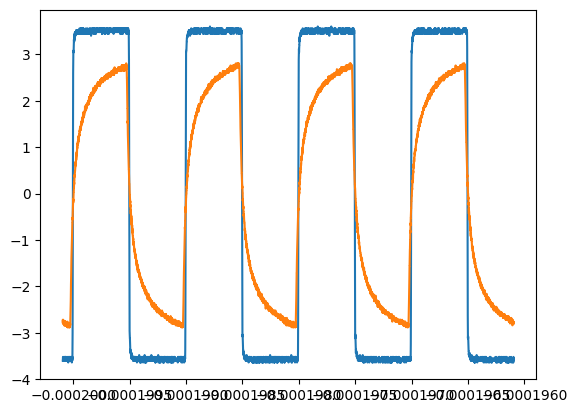

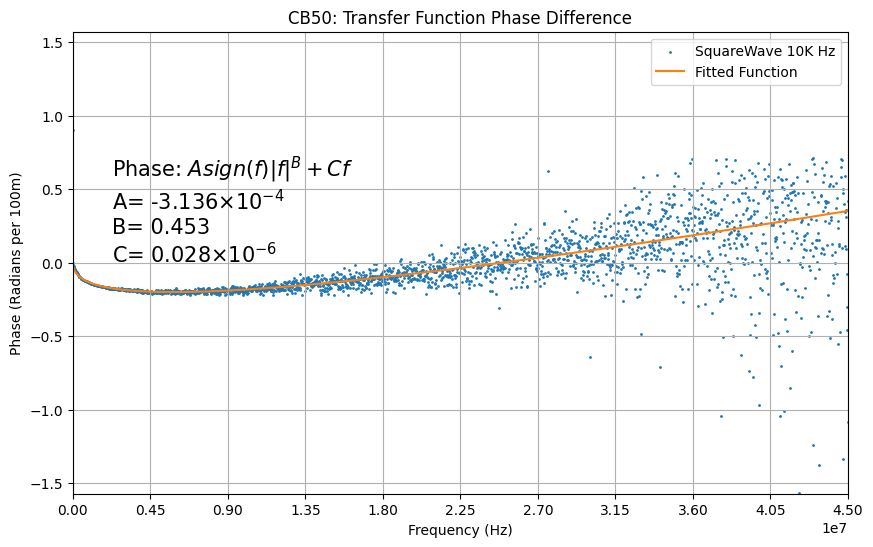

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 5.226058905848767
        x: [ 3.678e+00  6.077e+00 -5.967e+00 -7.255e+00]
      nit: 17
      jac: [ 1.431e-06  9.298e-06 -2.176e-05  1.055e-04]
 hess_inv: [[ 8.454e-02  3.050e-02 -2.502e-02 -1.001e-02]
            [ 3.050e-02  1.266e-02 -9.409e-03 -3.343e-03]
            [-2.502e-02 -9.409e-03  7.550e-03  2.848e-03]
            [-1.001e-02 -3.343e-03  2.848e-03  1.285e-03]]
     nfev: 352
     njev: 68


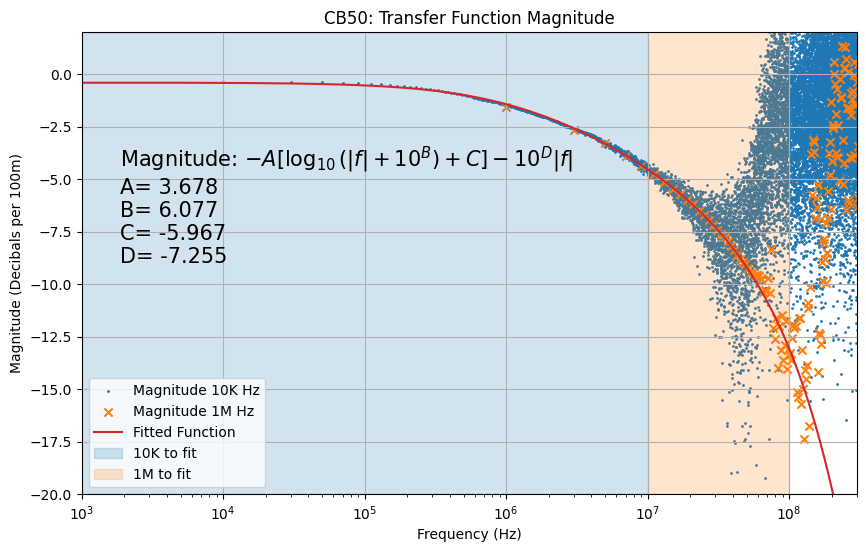

[ 3.67845954  6.07690949 -5.96716195 -7.25457511]


In [148]:
Transfer(cableNames[-1], cableNames[2], 3e7, 2.5/5e6, 5e7, switch_range= (1e7, 1e8))

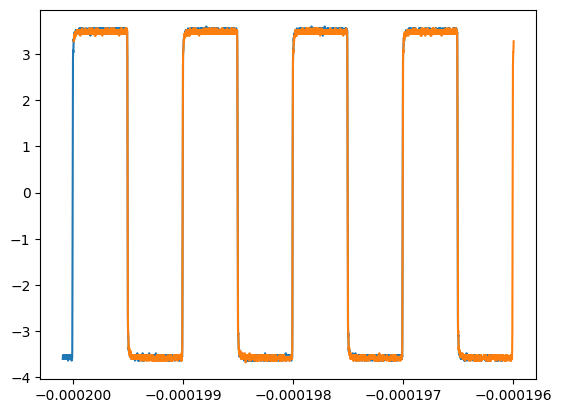

c:\Users\kolaj\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


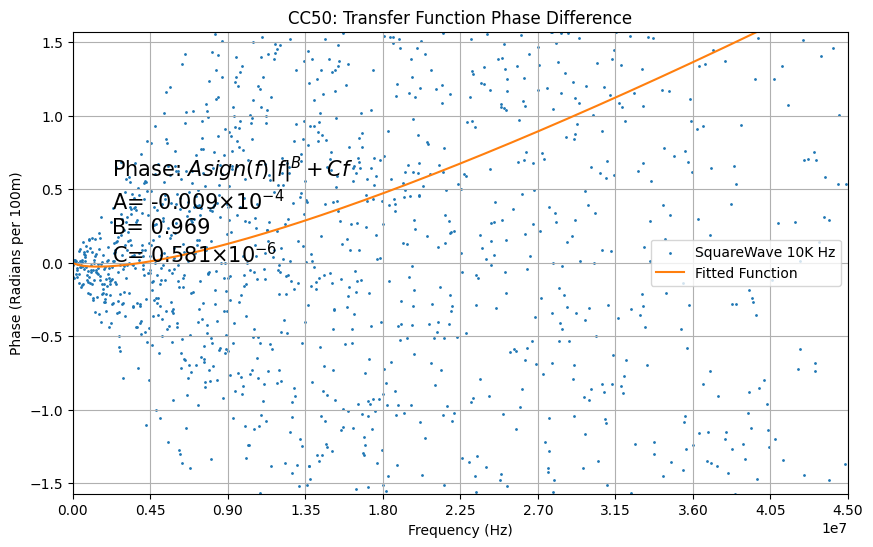

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 45.0423932433387
        x: [ 1.081e+00  4.929e+00 -5.351e+00 -1.505e+01]
      nit: 55
      jac: [ 1.431e-06  4.768e-07  2.384e-06  0.000e+00]
 hess_inv: [[ 8.187e-03  2.643e-02 -1.118e-02 -5.716e-01]
            [ 2.643e-02  1.794e-01 -3.877e-02 -5.779e+00]
            [-1.118e-02 -3.877e-02  1.594e-02  8.420e-01]
            [-5.716e-01 -5.779e+00  8.420e-01  1.717e+04]]
     nfev: 315
     njev: 63


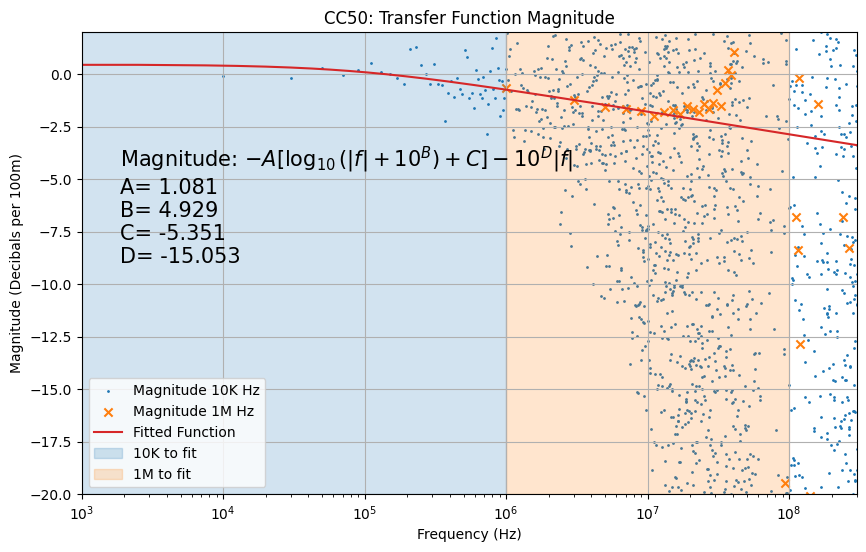

[  1.08119138   4.92889948  -5.35087593 -15.05271439]


In [149]:
Transfer(cableNames[-1], cableNames[1], 3e7, 0, 1.5e7, switch_range = (1e6, 1e8))

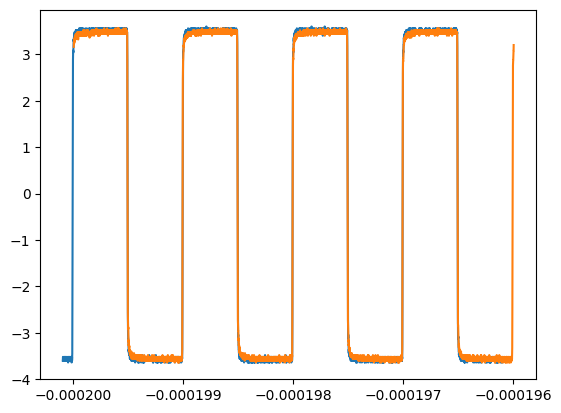

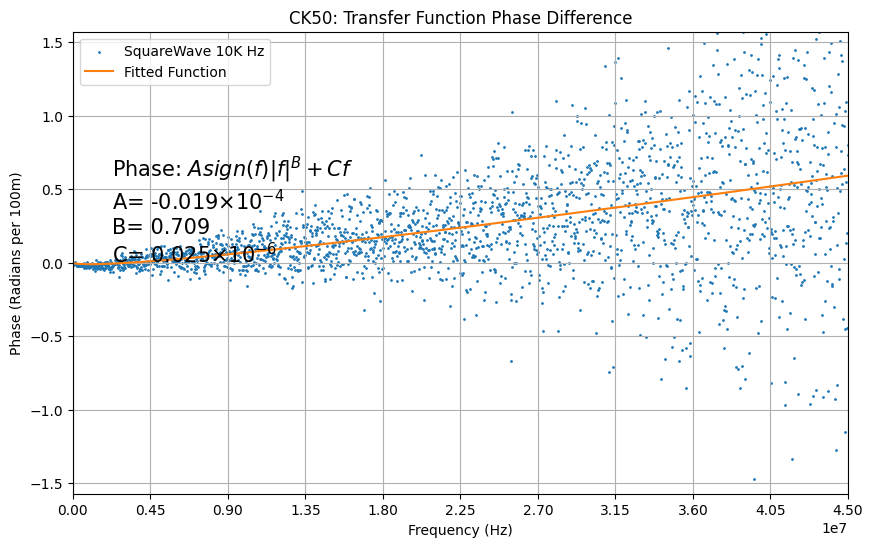

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.36674588909459127
        x: [ 9.090e-01  6.075e+00 -5.992e+00 -4.489e+01]
      nit: 78
      jac: [ 8.464e-06 -3.353e-08  6.162e-06  0.000e+00]
 hess_inv: [[ 4.320e-02  8.220e-02 -6.038e-02 -8.271e-02]
            [ 8.220e-02  1.793e-01 -1.187e-01 -1.829e+00]
            [-6.038e-02 -1.187e-01  8.562e-02  3.170e-01]
            [-8.271e-02 -1.829e+00  3.170e-01  1.324e+02]]
     nfev: 470
     njev: 94


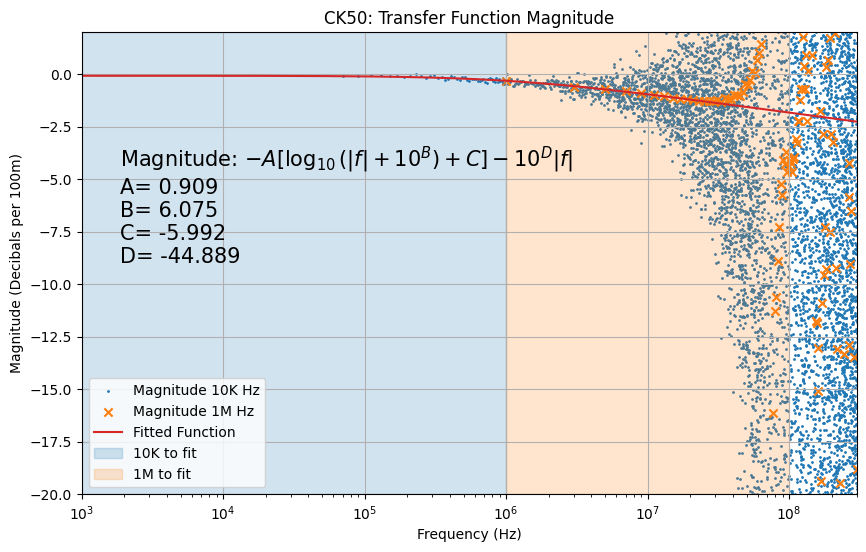

[  0.90901264   6.07537235  -5.99151018 -44.88943756]


In [150]:
Transfer(cableNames[-1], cableNames[3], 3e7, 0, 2e7, switch_range= (1e6, 1e8))

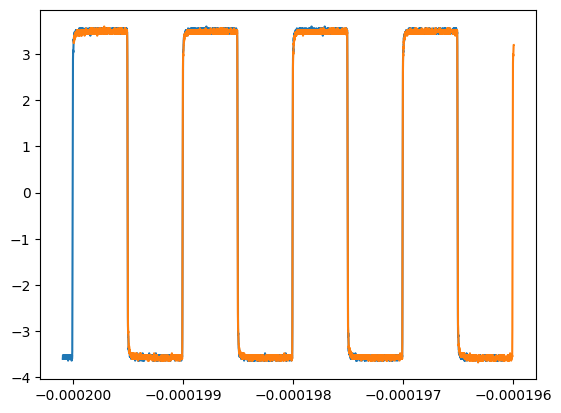

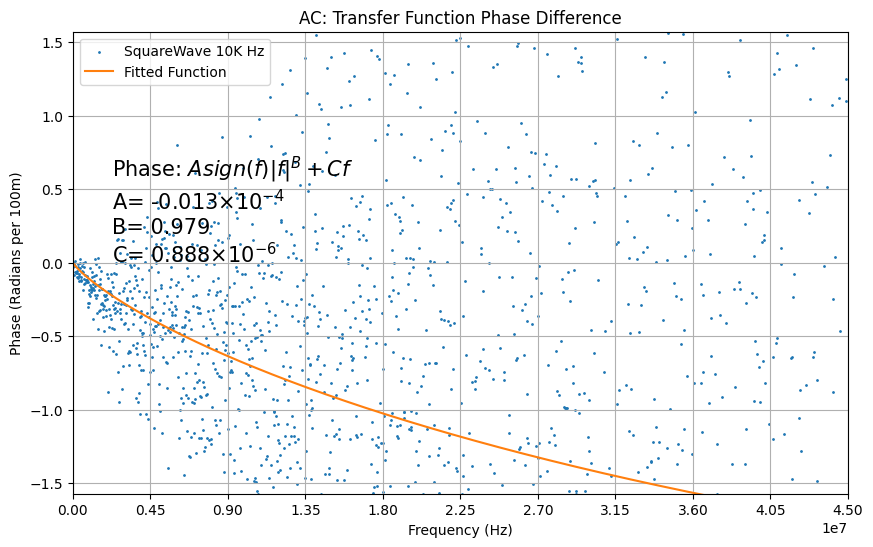

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 23.611837166906987
        x: [ 2.437e+00  5.972e+00 -5.893e+00 -1.591e+01]
      nit: 57
      jac: [ 2.384e-07  1.192e-06 -2.146e-06  0.000e+00]
 hess_inv: [[ 2.798e-02  2.097e-02 -1.515e-02  1.815e+01]
            [ 2.097e-02  1.922e-02 -1.188e-02  1.506e+00]
            [-1.515e-02 -1.188e-02  8.372e-03 -9.156e+00]
            [ 1.815e+01  1.506e+00 -9.156e+00  3.058e+06]]
     nfev: 320
     njev: 64


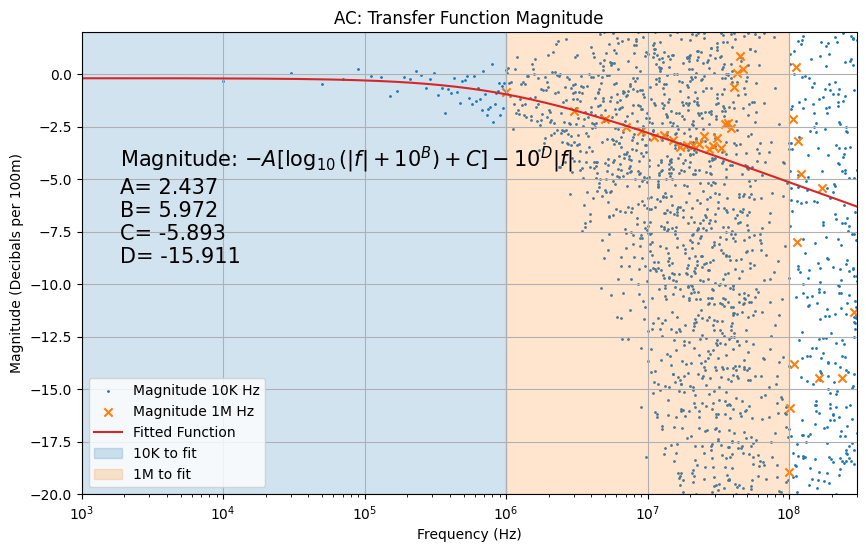

[  2.43743182   5.97229692  -5.89298121 -15.91074905]


In [151]:
Transfer(cableNames[-1], cableNames[0], 3e7, 0, 2e7, switch_range= (1e6, 1e8))

In [ ]:
for cables in cableNames:
    print(f'{cables:14}', end=' ')
    
    for key in list(data.keys()):
        if(cables in key):
        if(cables in key and WaveForms[1] in key):
            print(f'{key:14}', end=' ')
            times = data[key][:,0]
            voltage = data[key][:,1]
            freqs = fftfreq(len(times), np.mean(np.diff(times)))

            odd_mask10K = np.full(len(freqs), False)
            odd_mask10K[4::8] = True
            odd_mask1M = np.full(len(freqs), False)
            odd_mask1M[400::800] = True

            magnitude = np.abs(fft(voltage))
            phase = np.angle(fft(voltage))

            # plt.plot(times, voltage)
            # plt.title(key)
            # plt.show()

            odd_mask = odd_mask10K
            if '1M' in key:
                odd_mask = odd_mask1M

            plt.scatter(freqs[odd_mask], magnitude[odd_mask], s=1)
            plt.title(key)
            plt.xlim(0,1e8)
            plt.show()

            plt.scatter(freqs[odd_mask], phase[odd_mask], s=1)
            plt.title(key)
            plt.xlim(-1e8,1e8)
            plt.show()

            

            


    print('')



IndentationError: expected an indented block after 'if' statement on line 5 (2234384691.py, line 6)

In [ ]:
plt.plot(Pulse_12ns_CB50[:, 0], Pulse_12ns_CB50[:, 1], label='Pulse_12ns_CB50')
plt.legend()
plt.show()

plt.plot(Pulse_12ns_ShortCable[:, 0], Pulse_12ns_ShortCable[:, 1], label='Pulse_12ns_ShortCable')
plt.legend()
plt.show()

plt.plot(Pulse_24ns_CB50[:, 0], Pulse_24ns_CB50[:, 1], label='Pulse_24ns_CB50')
plt.legend()
plt.show()

plt.plot(Pulse_24ns_ShortCable[:, 0], Pulse_24ns_ShortCable[:, 1], label='Pulse_24ns_ShortCable')
plt.legend()
plt.show()

plt.plot(SineWave_160M_CB50[:100, 0], SineWave_160M_CB50[:100, 1], label='SineWave_160M_CB50')
plt.legend()
plt.show()

plt.plot(SineWave_160M_ShortCable[:100, 0], SineWave_160M_ShortCable[:100, 1], label='SineWave_160M_ShortCable')
plt.legend()
plt.show()

plt.plot(SquareWave_10K_CB50[:, 0], SquareWave_10K_CB50[:, 1], label='SquareWave_10K_CB50')
plt.legend()
plt.show()

plt.plot(SquareWave_10K_ShortCable[:, 0], SquareWave_10K_ShortCable[:, 1], label='SquareWave_10K_ShortCable')
plt.legend()
plt.show()

plt.plot(SquareWave_1M_CB50[:10000, 0], SquareWave_1M_CB50[:10000, 1], label='SquareWave_1M_CB50')
plt.legend()
plt.show()

plt.plot(SquareWave_1M_ShortCable[:10000, 0], SquareWave_1M_ShortCable[:10000, 1], label='SquareWave_1M_ShortCable')
plt.legend()
plt.show()
